In [11]:
# !pip install openwakeword
# !pip install speechbrain
# !pip install datasets
# !pip install scipy matplotlib

In [12]:
import collections
from numpy.lib.format import open_memmap
import openwakeword.utils
import openwakeword.metrics


import matplotlib.pyplot as plt
import torch
from torch import nn
import IPython.display as ipd

import datasets
import numpy as np
import scipy.io.wavfile

import urllib.request

import os
import soundfile as sf
from scipy.io import wavfile
from tqdm import tqdm
import librosa

import random
import torchaudio
import warnings

warnings.filterwarnings("ignore")

In [13]:
# --- Parameters ---
ROOT = "./data"
TARGET_FOLDER = os.path.join(ROOT, "negative_clips")
os.makedirs(TARGET_FOLDER, exist_ok=True)

NUM_CLIPS = 5000
MIN_DURATION_SEC = 1.0
SAMPLE_RATE = 16000

# --- Dataset loader ---
from torchaudio.datasets import LIBRISPEECH
dataset = LIBRISPEECH(root=ROOT, url="train-clean-100", download=True)

# --- Helper: save clip ---
def save_clip(waveform, sr, out_path):
    if waveform.size(0) > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(waveform)
    wav_data = (waveform.squeeze().numpy() * 32767).astype('int16')
    wavfile.write(out_path, SAMPLE_RATE, wav_data)

# --- Pick random 5000 clips ---
count = 0
indices = list(range(len(dataset)))
random.shuffle(indices)

for idx in tqdm(indices, total=len(indices)):
    if count >= NUM_CLIPS:
        break
    waveform, sr, *_ = dataset[idx]
    duration = waveform.size(1) / sr
    if duration < MIN_DURATION_SEC:
        continue
    out_fname = f"libri_neg_{count:05d}.wav"
    out_path = os.path.join(TARGET_FOLDER, out_fname)
    save_clip(waveform, sr, out_path)
    count += 1

print(f"Saved {count} negative English speech clips into {TARGET_FOLDER}")


In [14]:
ROOT = "./data"
TARGET_FOLDER = os.path.join(ROOT, "negative_clips")
os.makedirs(TARGET_FOLDER, exist_ok=True)

NUM_CLIPS = 5000
MIN_DURATION_SEC = 1.0
SAMPLE_RATE = 16000

In [15]:
all_files = []
for subdir, dirs, files in os.walk(ROOT):
    for f in files:
        if f.endswith(".flac"):
            all_files.append(os.path.join(subdir, f))


print(f"Found {len(all_files)} total .flac files")


In [16]:
import shutil

for i, fpath in enumerate(tqdm(all_files, total=len(all_files))):
    new_name = f"libri_neg_{i:05d}.flac"
    target_path = os.path.join(TARGET_FOLDER, new_name)
    shutil.copy2(fpath, target_path)

print(f"Copied all files to {TARGET_FOLDER}")

In [17]:


INPUT_FOLDER = "./data/negative_clips"
OUTPUT_FOLDER = "./data/negative_wav"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Filter file valid FLAC
all_flacs = [f for f in os.listdir(INPUT_FOLDER) if f.endswith(".flac") and not f.startswith("._")]
print(f"Found {len(all_flacs)} candidate FLAC files")

max_files = 5000
converted_count = 0

for f in tqdm(all_flacs, total=len(all_flacs)):
    if converted_count >= max_files:
        break

    input_path = os.path.join(INPUT_FOLDER, f)
    output_name = f.replace(".flac", ".wav")
    output_path = os.path.join(OUTPUT_FOLDER, output_name)

    try:
        data, sr = sf.read(input_path)
        if sr != 16000:
            data = librosa.resample(data, orig_sr=sr, target_sr=16000)
            sr = 16000
        wav_data = (data * 32767).astype('int16')
        wavfile.write(output_path, sr, wav_data)
        converted_count += 1
    except Exception as e:
        print(f"Skipped {f}: {e}")

print(f"Done. Converted {converted_count} WAV files to {OUTPUT_FOLDER}")


# ⇲ Compute Audio Embeddings

Create audio pre-processing object to get openwakeword audio embeddings

In [19]:
model_dir = "./resources/models"
os.makedirs(model_dir, exist_ok=True)

List Model and URL corresponding

In [20]:
models = {
    "embedding_model.onnx": "https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.onnx",
    "embedding_model.tflite": "https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.tflite",
    "melspectrogram.onnx": "https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.onnx",
    "melspectrogram.tflite": "https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.tflite"
}

In [21]:
for filename, url in models.items():
    file_path = os.path.join(model_dir, filename)
    if not os.path.exists(file_path):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, file_path)
    else:
        print(f"Found {filename}.")


Found embedding_model.onnx.
Found embedding_model.tflite.
Found melspectrogram.onnx.
Found melspectrogram.tflite.


In [22]:
F = openwakeword.utils.AudioFeatures(
    melspec_model_path=f"{model_dir}/melspectrogram.onnx",
    embedding_model_path=f"{model_dir}/embedding_model.onnx",
    inference_framework="onnx",
)

## ⌀ Negative Clips

Get negative example paths, filtering out clips that are too long or too short

 pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 --index-url https://download.pytorch.org/whl/cpu

In [23]:
import openwakeword.data

In [24]:
negative_clips, negative_durations = openwakeword.data.filter_audio_paths(
    [
        "./data/fma_sample",
        "./data/fsd50k_sample",
        "./data/negative_wav",
    ],
    min_length_secs=1.0, # minimum clip length in seconds
    max_length_secs=60*30, # maximum clip length in seconds
    duration_method="header" # use the file header to calculate duration
)

print(f"{len(negative_clips)} negative clips after filtering, representing ~{sum(negative_durations)//3600} hours")

200it [00:00, 6162.57it/s]
100%|██████████| 200/200 [00:02<00:00, 99.57it/s] 
1000it [00:00, 16231.39it/s]
100%|██████████| 1000/1000 [00:04<00:00, 206.23it/s]
5005it [00:00, 16955.35it/s]
100%|██████████| 5005/5005 [00:29<00:00, 172.49it/s]

6097 negative clips after filtering, representing ~22.0 hours


Use HuggingFace datasets to load files from disk by batches, because:
- Load lazy
- Memmory-Mapping for doesn't load entire in RAM
- map() -> feature extraction, augmentation
- filter() -> remove audio too long/short

In [25]:
audio_dataset = datasets.Dataset.from_dict({
    "audio": negative_clips
})

In [26]:
audio_dataset = audio_dataset.cast_column(
    "audio",
    datasets.Audio(sampling_rate=16000)
)

- Get Audio Embeddings (features) for negative clips and save to .npy file
- Process files by batch and save to Numpy memory mapped file so that
- An array larger than the available system memory can be created

In [27]:
batch_size = 64 # number of files to load, compute features, and write to mmap at a time

In [28]:
clip_size = 3 # The desired window size (in seconds) for the trained openWakeWord model

In [29]:
N_total = int(sum(negative_durations)//clip_size) # Maximum number of rows in mmap file

N_total

26466

In [30]:
n_feature_cols = F.get_embedding_shape(clip_size)

n_feature_cols

(28, 96)

In [31]:
output_file = "negative_features.npy"

In [32]:
output_array_shape = (N_total, n_feature_cols[0], n_feature_cols[1])

output_array_shape

(26466, 28, 96)

Remove .npy before create mmap

In [33]:
for f in [output_file, output_file + ".npy"]:
    if os.path.exists(f):
        os.remove(f)

In [34]:
fp = open_memmap(
    output_file,
    mode="w+",
    dtype=np.float32,
    shape=output_array_shape
)

fp

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [35]:
row_counter = 0

In [36]:
print("\n===== START PROCESS =====")
print(f"Total rows: {audio_dataset.num_rows}")
print(f"Batch size: {batch_size}")
print(f"Expected batches: {int(np.ceil(audio_dataset.num_rows / batch_size))}")
print("")

for i in tqdm(np.arange(0, audio_dataset.num_rows, batch_size)):
    print(f"\n--- Batch index: {int(i / batch_size)} ---")

    print("Loading audio batch...")
    block = audio_dataset[i:i + batch_size]["audio"]
    print(f"Loaded {len(block)} clips")

    print("Converting to int16 arrays...")
    wav_data = [(j["array"] * 32767).astype(np.int16) for j in block]
    print("Conversion done.")

    print("Stacking clips (pad/trim)...")
    wav_data = openwakeword.data.stack_clips(
        wav_data,
        clip_size=16000 * clip_size
    ).astype(np.int16)
    print("Stack clips done.")

    print("Computing embeddings...")
    features = F.embed_clips(
        x=wav_data,
        batch_size=1024,
        ncpu=8
    )
    print(f"Embedding done. features.shape = {features.shape}")

    print("Saving to mmap...")

    rows_needed = features.shape[0]

    if row_counter + rows_needed > N_total:
        print(f"Final batch: writing {N_total - row_counter} rows then break.")
        fp[row_counter:N_total, :, :] = features[0:N_total - row_counter]
        fp.flush()
        break

    else:
        print(f"Writing rows {row_counter} → {row_counter + rows_needed}")
        fp[row_counter:row_counter + rows_needed, :, :] = features
        row_counter += rows_needed
        fp.flush()


===== START PROCESS =====
Total rows: 6097
Batch size: 64
Expected batches: 96



  0%|          | 0/96 [00:00<?, ?it/s]


--- Batch index: 0 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...
Embedding done. features.shape = (640, 28, 96)
Saving to mmap...
Writing rows 0 → 640


  1%|          | 1/96 [00:15<24:13, 15.30s/it]


--- Batch index: 1 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


  2%|▏         | 2/96 [00:23<17:06, 10.92s/it]

Embedding done. features.shape = (640, 28, 96)
Saving to mmap...
Writing rows 640 → 1280

--- Batch index: 2 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


  3%|▎         | 3/96 [00:31<15:00,  9.68s/it]

Embedding done. features.shape = (638, 28, 96)
Saving to mmap...
Writing rows 1280 → 1918

--- Batch index: 3 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...
Embedding done. features.shape = (234, 28, 96)
Saving to mmap...
Writing rows 1918 → 2152


  4%|▍         | 4/96 [00:34<10:53,  7.11s/it]


--- Batch index: 4 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


  5%|▌         | 5/96 [00:37<08:31,  5.62s/it]

Embedding done. features.shape = (249, 28, 96)
Saving to mmap...
Writing rows 2152 → 2401

--- Batch index: 5 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


  6%|▋         | 6/96 [00:40<06:51,  4.57s/it]

Embedding done. features.shape = (222, 28, 96)
Saving to mmap...
Writing rows 2401 → 2623

--- Batch index: 6 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


  7%|▋         | 7/96 [00:42<05:45,  3.89s/it]

Embedding done. features.shape = (207, 28, 96)
Saving to mmap...
Writing rows 2623 → 2830

--- Batch index: 7 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


  8%|▊         | 8/96 [00:44<04:56,  3.37s/it]

Embedding done. features.shape = (192, 28, 96)
Saving to mmap...
Writing rows 2830 → 3022

--- Batch index: 8 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


  9%|▉         | 9/96 [00:47<04:34,  3.15s/it]

Embedding done. features.shape = (228, 28, 96)
Saving to mmap...
Writing rows 3022 → 3250

--- Batch index: 9 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 10%|█         | 10/96 [00:50<04:15,  2.98s/it]

Embedding done. features.shape = (228, 28, 96)
Saving to mmap...
Writing rows 3250 → 3478

--- Batch index: 10 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 11%|█▏        | 11/96 [00:52<04:00,  2.83s/it]

Embedding done. features.shape = (210, 28, 96)
Saving to mmap...
Writing rows 3478 → 3688

--- Batch index: 11 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 12%|█▎        | 12/96 [00:54<03:39,  2.61s/it]

Embedding done. features.shape = (184, 28, 96)
Saving to mmap...
Writing rows 3688 → 3872

--- Batch index: 12 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 14%|█▎        | 13/96 [00:56<03:27,  2.50s/it]

Embedding done. features.shape = (194, 28, 96)
Saving to mmap...
Writing rows 3872 → 4066

--- Batch index: 13 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 15%|█▍        | 14/96 [00:59<03:19,  2.43s/it]

Embedding done. features.shape = (195, 28, 96)
Saving to mmap...
Writing rows 4066 → 4261

--- Batch index: 14 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 16%|█▌        | 15/96 [01:00<02:53,  2.14s/it]

Embedding done. features.shape = (125, 28, 96)
Saving to mmap...
Writing rows 4261 → 4386

--- Batch index: 15 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 17%|█▋        | 16/96 [01:03<03:03,  2.29s/it]

Embedding done. features.shape = (226, 28, 96)
Saving to mmap...
Writing rows 4386 → 4612

--- Batch index: 16 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 18%|█▊        | 17/96 [01:05<02:59,  2.27s/it]

Embedding done. features.shape = (186, 28, 96)
Saving to mmap...
Writing rows 4612 → 4798

--- Batch index: 17 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 19%|█▉        | 18/96 [01:08<03:19,  2.56s/it]

Embedding done. features.shape = (275, 28, 96)
Saving to mmap...
Writing rows 4798 → 5073

--- Batch index: 18 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 20%|█▉        | 19/96 [01:11<03:33,  2.78s/it]

Embedding done. features.shape = (277, 28, 96)
Saving to mmap...
Writing rows 5073 → 5350

--- Batch index: 19 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 21%|██        | 20/96 [01:15<03:39,  2.89s/it]

Embedding done. features.shape = (280, 28, 96)
Saving to mmap...
Writing rows 5350 → 5630

--- Batch index: 20 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 22%|██▏       | 21/96 [01:18<03:46,  3.02s/it]

Embedding done. features.shape = (292, 28, 96)
Saving to mmap...
Writing rows 5630 → 5922

--- Batch index: 21 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 23%|██▎       | 22/96 [01:21<03:49,  3.11s/it]

Embedding done. features.shape = (292, 28, 96)
Saving to mmap...
Writing rows 5922 → 6214

--- Batch index: 22 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 24%|██▍       | 23/96 [01:24<03:47,  3.12s/it]

Embedding done. features.shape = (271, 28, 96)
Saving to mmap...
Writing rows 6214 → 6485

--- Batch index: 23 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 25%|██▌       | 24/96 [01:27<03:40,  3.06s/it]

Embedding done. features.shape = (246, 28, 96)
Saving to mmap...
Writing rows 6485 → 6731

--- Batch index: 24 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 26%|██▌       | 25/96 [01:31<03:45,  3.17s/it]

Embedding done. features.shape = (292, 28, 96)
Saving to mmap...
Writing rows 6731 → 7023

--- Batch index: 25 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 27%|██▋       | 26/96 [01:34<03:49,  3.28s/it]

Embedding done. features.shape = (282, 28, 96)
Saving to mmap...
Writing rows 7023 → 7305

--- Batch index: 26 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 28%|██▊       | 27/96 [01:38<03:49,  3.33s/it]

Embedding done. features.shape = (271, 28, 96)
Saving to mmap...
Writing rows 7305 → 7576

--- Batch index: 27 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 29%|██▉       | 28/96 [01:40<03:33,  3.14s/it]

Embedding done. features.shape = (187, 28, 96)
Saving to mmap...
Writing rows 7576 → 7763

--- Batch index: 28 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 30%|███       | 29/96 [01:44<03:40,  3.30s/it]

Embedding done. features.shape = (262, 28, 96)
Saving to mmap...
Writing rows 7763 → 8025

--- Batch index: 29 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 31%|███▏      | 30/96 [01:48<03:50,  3.49s/it]

Embedding done. features.shape = (272, 28, 96)
Saving to mmap...
Writing rows 8025 → 8297

--- Batch index: 30 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 32%|███▏      | 31/96 [01:52<04:00,  3.71s/it]

Embedding done. features.shape = (261, 28, 96)
Saving to mmap...
Writing rows 8297 → 8558

--- Batch index: 31 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 33%|███▎      | 32/96 [01:57<04:21,  4.09s/it]

Embedding done. features.shape = (294, 28, 96)
Saving to mmap...
Writing rows 8558 → 8852

--- Batch index: 32 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 34%|███▍      | 33/96 [02:02<04:28,  4.26s/it]

Embedding done. features.shape = (263, 28, 96)
Saving to mmap...
Writing rows 8852 → 9115

--- Batch index: 33 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 35%|███▌      | 34/96 [02:07<04:45,  4.60s/it]

Embedding done. features.shape = (273, 28, 96)
Saving to mmap...
Writing rows 9115 → 9388

--- Batch index: 34 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 36%|███▋      | 35/96 [02:14<05:20,  5.25s/it]

Embedding done. features.shape = (295, 28, 96)
Saving to mmap...
Writing rows 9388 → 9683

--- Batch index: 35 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 38%|███▊      | 36/96 [02:20<05:32,  5.53s/it]

Embedding done. features.shape = (268, 28, 96)
Saving to mmap...
Writing rows 9683 → 9951

--- Batch index: 36 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 39%|███▊      | 37/96 [02:27<05:50,  5.94s/it]

Embedding done. features.shape = (295, 28, 96)
Saving to mmap...
Writing rows 9951 → 10246

--- Batch index: 37 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 40%|███▉      | 38/96 [02:34<06:06,  6.32s/it]

Embedding done. features.shape = (290, 28, 96)
Saving to mmap...
Writing rows 10246 → 10536

--- Batch index: 38 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 41%|████      | 39/96 [02:41<06:02,  6.36s/it]

Embedding done. features.shape = (266, 28, 96)
Saving to mmap...
Writing rows 10536 → 10802

--- Batch index: 39 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 42%|████▏     | 40/96 [02:48<06:07,  6.57s/it]

Embedding done. features.shape = (302, 28, 96)
Saving to mmap...
Writing rows 10802 → 11104

--- Batch index: 40 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 43%|████▎     | 41/96 [02:55<06:04,  6.62s/it]

Embedding done. features.shape = (295, 28, 96)
Saving to mmap...
Writing rows 11104 → 11399

--- Batch index: 41 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 44%|████▍     | 42/96 [03:00<05:40,  6.31s/it]

Embedding done. features.shape = (256, 28, 96)
Saving to mmap...
Writing rows 11399 → 11655

--- Batch index: 42 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 45%|████▍     | 43/96 [03:07<05:35,  6.32s/it]

Embedding done. features.shape = (281, 28, 96)
Saving to mmap...
Writing rows 11655 → 11936

--- Batch index: 43 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 46%|████▌     | 44/96 [03:12<05:20,  6.17s/it]

Embedding done. features.shape = (276, 28, 96)
Saving to mmap...
Writing rows 11936 → 12212

--- Batch index: 44 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 47%|████▋     | 45/96 [03:18<05:13,  6.15s/it]

Embedding done. features.shape = (289, 28, 96)
Saving to mmap...
Writing rows 12212 → 12501

--- Batch index: 45 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 48%|████▊     | 46/96 [03:24<04:58,  5.98s/it]

Embedding done. features.shape = (266, 28, 96)
Saving to mmap...
Writing rows 12501 → 12767

--- Batch index: 46 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 49%|████▉     | 47/96 [03:29<04:41,  5.74s/it]

Embedding done. features.shape = (261, 28, 96)
Saving to mmap...
Writing rows 12767 → 13028

--- Batch index: 47 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 50%|█████     | 48/96 [03:35<04:36,  5.77s/it]

Embedding done. features.shape = (287, 28, 96)
Saving to mmap...
Writing rows 13028 → 13315

--- Batch index: 48 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 51%|█████     | 49/96 [03:41<04:27,  5.69s/it]

Embedding done. features.shape = (271, 28, 96)
Saving to mmap...
Writing rows 13315 → 13586

--- Batch index: 49 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 52%|█████▏    | 50/96 [03:46<04:12,  5.50s/it]

Embedding done. features.shape = (257, 28, 96)
Saving to mmap...
Writing rows 13586 → 13843

--- Batch index: 50 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 53%|█████▎    | 51/96 [03:51<04:02,  5.39s/it]

Embedding done. features.shape = (262, 28, 96)
Saving to mmap...
Writing rows 13843 → 14105

--- Batch index: 51 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 54%|█████▍    | 52/96 [03:56<03:55,  5.35s/it]

Embedding done. features.shape = (274, 28, 96)
Saving to mmap...
Writing rows 14105 → 14379

--- Batch index: 52 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 55%|█████▌    | 53/96 [04:02<03:55,  5.47s/it]

Embedding done. features.shape = (301, 28, 96)
Saving to mmap...
Writing rows 14379 → 14680

--- Batch index: 53 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 56%|█████▋    | 54/96 [04:08<03:54,  5.59s/it]

Embedding done. features.shape = (301, 28, 96)
Saving to mmap...
Writing rows 14680 → 14981

--- Batch index: 54 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 57%|█████▋    | 55/96 [04:13<03:50,  5.62s/it]

Embedding done. features.shape = (304, 28, 96)
Saving to mmap...
Writing rows 14981 → 15285

--- Batch index: 55 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 58%|█████▊    | 56/96 [04:19<03:43,  5.59s/it]

Embedding done. features.shape = (297, 28, 96)
Saving to mmap...
Writing rows 15285 → 15582

--- Batch index: 56 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 59%|█████▉    | 57/96 [04:24<03:33,  5.46s/it]

Embedding done. features.shape = (284, 28, 96)
Saving to mmap...
Writing rows 15582 → 15866

--- Batch index: 57 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 60%|██████    | 58/96 [04:29<03:22,  5.34s/it]

Embedding done. features.shape = (282, 28, 96)
Saving to mmap...
Writing rows 15866 → 16148

--- Batch index: 58 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 61%|██████▏   | 59/96 [04:34<03:09,  5.11s/it]

Embedding done. features.shape = (254, 28, 96)
Saving to mmap...
Writing rows 16148 → 16402

--- Batch index: 59 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 62%|██████▎   | 60/96 [04:38<03:00,  5.02s/it]

Embedding done. features.shape = (273, 28, 96)
Saving to mmap...
Writing rows 16402 → 16675

--- Batch index: 60 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 64%|██████▎   | 61/96 [04:44<02:57,  5.06s/it]

Embedding done. features.shape = (286, 28, 96)
Saving to mmap...
Writing rows 16675 → 16961

--- Batch index: 61 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 65%|██████▍   | 62/96 [04:49<02:52,  5.09s/it]

Embedding done. features.shape = (287, 28, 96)
Saving to mmap...
Writing rows 16961 → 17248

--- Batch index: 62 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 66%|██████▌   | 63/96 [04:54<02:49,  5.14s/it]

Embedding done. features.shape = (288, 28, 96)
Saving to mmap...
Writing rows 17248 → 17536

--- Batch index: 63 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 67%|██████▋   | 64/96 [04:59<02:44,  5.15s/it]

Embedding done. features.shape = (281, 28, 96)
Saving to mmap...
Writing rows 17536 → 17817

--- Batch index: 64 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 68%|██████▊   | 65/96 [05:05<02:42,  5.23s/it]

Embedding done. features.shape = (284, 28, 96)
Saving to mmap...
Writing rows 17817 → 18101

--- Batch index: 65 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 69%|██████▉   | 66/96 [05:10<02:38,  5.28s/it]

Embedding done. features.shape = (293, 28, 96)
Saving to mmap...
Writing rows 18101 → 18394

--- Batch index: 66 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 70%|██████▉   | 67/96 [05:15<02:28,  5.11s/it]

Embedding done. features.shape = (266, 28, 96)
Saving to mmap...
Writing rows 18394 → 18660

--- Batch index: 67 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 71%|███████   | 68/96 [05:20<02:20,  5.03s/it]

Embedding done. features.shape = (265, 28, 96)
Saving to mmap...
Writing rows 18660 → 18925

--- Batch index: 68 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 72%|███████▏  | 69/96 [05:25<02:19,  5.16s/it]

Embedding done. features.shape = (293, 28, 96)
Saving to mmap...
Writing rows 18925 → 19218

--- Batch index: 69 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 73%|███████▎  | 70/96 [05:30<02:16,  5.25s/it]

Embedding done. features.shape = (290, 28, 96)
Saving to mmap...
Writing rows 19218 → 19508

--- Batch index: 70 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 74%|███████▍  | 71/96 [05:36<02:14,  5.40s/it]

Embedding done. features.shape = (301, 28, 96)
Saving to mmap...
Writing rows 19508 → 19809

--- Batch index: 71 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 75%|███████▌  | 72/96 [05:42<02:09,  5.38s/it]

Embedding done. features.shape = (282, 28, 96)
Saving to mmap...
Writing rows 19809 → 20091

--- Batch index: 72 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 76%|███████▌  | 73/96 [05:47<02:06,  5.49s/it]

Embedding done. features.shape = (294, 28, 96)
Saving to mmap...
Writing rows 20091 → 20385

--- Batch index: 73 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 77%|███████▋  | 74/96 [05:53<02:00,  5.47s/it]

Embedding done. features.shape = (283, 28, 96)
Saving to mmap...
Writing rows 20385 → 20668

--- Batch index: 74 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 78%|███████▊  | 75/96 [05:58<01:55,  5.48s/it]

Embedding done. features.shape = (278, 28, 96)
Saving to mmap...
Writing rows 20668 → 20946

--- Batch index: 75 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 79%|███████▉  | 76/96 [06:04<01:50,  5.53s/it]

Embedding done. features.shape = (271, 28, 96)
Saving to mmap...
Writing rows 20946 → 21217

--- Batch index: 76 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 80%|████████  | 77/96 [06:09<01:44,  5.50s/it]

Embedding done. features.shape = (274, 28, 96)
Saving to mmap...
Writing rows 21217 → 21491

--- Batch index: 77 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 81%|████████▏ | 78/96 [06:14<01:36,  5.37s/it]

Embedding done. features.shape = (273, 28, 96)
Saving to mmap...
Writing rows 21491 → 21764

--- Batch index: 78 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 82%|████████▏ | 79/96 [06:19<01:30,  5.30s/it]

Embedding done. features.shape = (266, 28, 96)
Saving to mmap...
Writing rows 21764 → 22030

--- Batch index: 79 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 83%|████████▎ | 80/96 [06:25<01:25,  5.34s/it]

Embedding done. features.shape = (281, 28, 96)
Saving to mmap...
Writing rows 22030 → 22311

--- Batch index: 80 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 84%|████████▍ | 81/96 [06:30<01:20,  5.36s/it]

Embedding done. features.shape = (283, 28, 96)
Saving to mmap...
Writing rows 22311 → 22594

--- Batch index: 81 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 85%|████████▌ | 82/96 [06:35<01:13,  5.26s/it]

Embedding done. features.shape = (262, 28, 96)
Saving to mmap...
Writing rows 22594 → 22856

--- Batch index: 82 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 86%|████████▋ | 83/96 [06:41<01:08,  5.24s/it]

Embedding done. features.shape = (274, 28, 96)
Saving to mmap...
Writing rows 22856 → 23130

--- Batch index: 83 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 88%|████████▊ | 84/96 [06:46<01:01,  5.16s/it]

Embedding done. features.shape = (269, 28, 96)
Saving to mmap...
Writing rows 23130 → 23399

--- Batch index: 84 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 89%|████████▊ | 85/96 [06:51<00:56,  5.14s/it]

Embedding done. features.shape = (270, 28, 96)
Saving to mmap...
Writing rows 23399 → 23669

--- Batch index: 85 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 90%|████████▉ | 86/96 [06:56<00:52,  5.30s/it]

Embedding done. features.shape = (293, 28, 96)
Saving to mmap...
Writing rows 23669 → 23962

--- Batch index: 86 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 91%|█████████ | 87/96 [07:02<00:49,  5.55s/it]

Embedding done. features.shape = (297, 28, 96)
Saving to mmap...
Writing rows 23962 → 24259

--- Batch index: 87 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 92%|█████████▏| 88/96 [07:09<00:45,  5.72s/it]

Embedding done. features.shape = (301, 28, 96)
Saving to mmap...
Writing rows 24259 → 24560

--- Batch index: 88 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 93%|█████████▎| 89/96 [07:13<00:38,  5.49s/it]

Embedding done. features.shape = (250, 28, 96)
Saving to mmap...
Writing rows 24560 → 24810

--- Batch index: 89 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 94%|█████████▍| 90/96 [07:19<00:32,  5.37s/it]

Embedding done. features.shape = (257, 28, 96)
Saving to mmap...
Writing rows 24810 → 25067

--- Batch index: 90 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 95%|█████████▍| 91/96 [07:24<00:27,  5.45s/it]

Embedding done. features.shape = (284, 28, 96)
Saving to mmap...
Writing rows 25067 → 25351

--- Batch index: 91 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 96%|█████████▌| 92/96 [07:30<00:22,  5.64s/it]

Embedding done. features.shape = (288, 28, 96)
Saving to mmap...
Writing rows 25351 → 25639

--- Batch index: 92 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 97%|█████████▋| 93/96 [07:36<00:17,  5.70s/it]

Embedding done. features.shape = (284, 28, 96)
Saving to mmap...
Writing rows 25639 → 25923

--- Batch index: 93 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 98%|█████████▊| 94/96 [07:42<00:11,  5.65s/it]

Embedding done. features.shape = (267, 28, 96)
Saving to mmap...
Writing rows 25923 → 26190

--- Batch index: 94 ---
Loading audio batch...
Loaded 64 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 99%|█████████▉| 95/96 [07:47<00:05,  5.47s/it]

Embedding done. features.shape = (258, 28, 96)
Saving to mmap...
Writing rows 26190 → 26448

--- Batch index: 95 ---
Loading audio batch...
Loaded 17 clips
Converting to int16 arrays...
Conversion done.
Stacking clips (pad/trim)...
Stack clips done.
Computing embeddings...


 99%|█████████▉| 95/96 [07:48<00:04,  4.93s/it]

Embedding done. features.shape = (68, 28, 96)
Saving to mmap...
Final batch: writing 18 rows then break.


In [37]:
print("\n===== Trimming mmap file =====")
openwakeword.data.trim_mmap(output_file)
print("===== FINISHED =====\n")


===== Trimming mmap file =====


Trimming empty rows: 26it [00:03,  7.62it/s]                        

===== FINISHED =====



Now we have all of the negative features prepared, and saved to fixed durations clips in Numpy array. For this data, the array is small at ~160MB, but in-practice the memory mapping allows to be very large.

## ✰ Positive Clips

The positive clips will be prepared in two way:
1. Mixing the synthetic positive clips with negative data at random SNRs to simulate noise data
2. Aligning the positive clips with background data such as that the end of the input window aligns with the end of the positive clip. This way the model will learn to predict the presence of the wakeword/phrase immediately after it is spoken.

In practice, there are other possible ways to augment the positive data (e.g, creating reverberation with room impulse response files, mixing with synthetic noise, etc.) but in pratice we have observed that mixing with realistic background data provides the best results.

After this preparation, the positive clips will be converted into the openWakeWord features in the same way as the negative files.

**Get positive example paths, filtering out clips that are too long or too short**

In [38]:
positive_clips, durations = openwakeword.data.filter_audio_paths(
    [
        "./data/turn_on_the_office_lights"
    ],
    min_length_secs=1.0,
    max_length_secs=2.0,
    duration_method="header" # use the file header to calculate duration
)

print(f"{len(positive_clips)} positive clips after filtering, representing ~{sum(durations)//3600} hours")

3388it [00:00, 11359.79it/s]
100%|██████████| 3388/3388 [00:26<00:00, 127.57it/s]

3203 positive clips after filtering, representing ~1.0 hours


Define starting point for each positive clip based on its length, so that each one ends between 0-200ms from the end of the total window size chosen for the model.

This results in the model being most confident in the prediction right after the end of the wakeword in the audio stream, reducing latency in operation.

Get start and end position for the positive audio in the full window

In [39]:
sr = 16000
total_length_seconds = 3 # must be some window length as that used for the negative examples
total_length = int(sr * total_length_seconds)

random delay (0-0.2s) -> make sure the audio don't need right position -> reduce overfitting

In [40]:
jitters = (np.random.uniform(0, 0.2, len(positive_clips)) * sr).astype(np.int32)

jitters

array([2096, 1165, 2734, ..., 2102, 2847, 2602],
      shape=(3203,), dtype=int32)

start position of wakeword for 3 seconds = total_length - (clip_length + jitter)


In [41]:
starts = [
    total_length
    -
    (
        int(np.ceil(i * sr)) + j
    ) for i,j in zip(durations, jitters)
]


starts

[np.int32(17298),
 np.int32(25472),
 np.int32(27433),
 np.int32(23977),
 np.int32(21507),
 np.int32(24443),
 np.int32(25897),
 np.int32(26499),
 np.int32(22444),
 np.int32(22845),
 np.int32(22037),
 np.int32(22104),
 np.int32(19777),
 np.int32(19270),
 np.int32(21553),
 np.int32(23705),
 np.int32(22111),
 np.int32(23358),
 np.int32(20841),
 np.int32(22556),
 np.int32(19945),
 np.int32(21770),
 np.int32(26852),
 np.int32(28263),
 np.int32(15186),
 np.int32(20709),
 np.int32(22351),
 np.int32(22853),
 np.int32(18397),
 np.int32(16784),
 np.int32(19196),
 np.int32(28129),
 np.int32(19709),
 np.int32(25526),
 np.int32(23310),
 np.int32(27095),
 np.int32(22258),
 np.int32(20944),
 np.int32(29036),
 np.int32(19813),
 np.int32(18406),
 np.int32(25693),
 np.int32(25380),
 np.int32(23733),
 np.int32(16465),
 np.int32(24825),
 np.int32(20674),
 np.int32(19106),
 np.int32(18468),
 np.int32(19572),
 np.int32(28989),
 np.int32(21254),
 np.int32(18900),
 np.int32(22453),
 np.int32(19286),
 np.int32(

end = clip_length + start_index

In [42]:
ends = [
    (int(i * sr) + j) for i, j in zip(durations, starts)
]

ends

[np.int32(45904),
 np.int32(46835),
 np.int32(45266),
 np.int32(47011),
 np.int32(45655),
 np.int32(46919),
 np.int32(47817),
 np.int32(46004),
 np.int32(46035),
 np.int32(45322),
 np.int32(47301),
 np.int32(47924),
 np.int32(47083),
 np.int32(47876),
 np.int32(47187),
 np.int32(47853),
 np.int32(45702),
 np.int32(44907),
 np.int32(47033),
 np.int32(46704),
 np.int32(47065),
 np.int32(46847),
 np.int32(46357),
 np.int32(45911),
 np.int32(46765),
 np.int32(47829),
 np.int32(45014),
 np.int32(47373),
 np.int32(45146),
 np.int32(46134),
 np.int32(44830),
 np.int32(46334),
 np.int32(47758),
 np.int32(46332),
 np.int32(45229),
 np.int32(45486),
 np.int32(47149),
 np.int32(45464),
 np.int32(47055),
 np.int32(47676),
 np.int32(44969),
 np.int32(47055),
 np.int32(46371),
 np.int32(46395),
 np.int32(46558),
 np.int32(47488),
 np.int32(46494),
 np.int32(46969),
 np.int32(45774),
 np.int32(45764),
 np.int32(47937),
 np.int32(47074),
 np.int32(46206),
 np.int32(46230),
 np.int32(46222),
 np.int32(

Create generator to mix the positive audio with background audio

In [43]:
batch_size = 8

In [44]:
mixing_generator = openwakeword.data.mix_clips_batch(
    foreground_clips = positive_clips,
    background_clips = negative_clips,
    combined_size = total_length,
    batch_size = batch_size,
    snr_low = 5,
    snr_high = 15,
    start_index = starts,
    volume_augmentation = True # Randomly scale the volume of the audio after mixing
)

(Optionally) listen to mixed clips to confirm that the mixing appears correctly

In [45]:
mixed_clips, labels, background_clips = next(mixing_generator)
ipd.display(ipd.Audio(mixed_clips[0], rate=16000, normalize=True, autoplay=False))

Iterate through the mixing generator, computing audio features for positive examples and saving them

In [46]:
N_total = len(positive_clips) # Maximum number of rows in mmap files

N_total

3203

In [47]:
n_feature_cols = F.get_embedding_shape(
    total_length_seconds
)

n_feature_cols

(28, 96)

In [48]:
output_file = "turn_on_the_office_lights_features.npy"

In [49]:
output_array_shape = (N_total, n_feature_cols[0], n_feature_cols[1])

output_array_shape

(3203, 28, 96)

Remove .npy before create mmap


In [50]:
for f in [output_file, output_file + ".npy"]:
    if os.path.exists(f):
        os.remove(f)

In [51]:
fp = open_memmap(
    output_file,
    "w+",
    dtype=np.float32,
    shape=output_array_shape
)

fp

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [52]:
row_counter = 0

In [53]:
print("===== START FEATURE EXTRACTION =====")
print(f"Total rows to process: {N_total}")
print(f"Batch size: {batch_size}")
print(f"Expected batches: {N_total // batch_size}")

row_counter = 0

for batch_idx, batch in enumerate(tqdm(mixing_generator, total=N_total//batch_size, desc="Processing batches")):

    # Unpack batch
    audio_batch, lbls, background = batch[0], batch[1], batch[2]
    print(f"\n--- Batch index: {batch_idx} ---")
    print(f"Audio batch shape: {audio_batch.shape}")

    # Compute embeddings
    print("Computing embeddings...")
    features = F.embed_clips(
        audio_batch,
        batch_size=256
    )
    print(f"Embeddings shape: {features.shape}")

    # Save computed features to memory-mapped file
    start_row = row_counter
    end_row = row_counter + features.shape[0]

    if end_row > N_total:
        # Truncate if last batch exceeds total rows
        print(f"Saving final partial batch: rows {start_row} → {N_total}")
        fp[start_row:N_total, :, :] = features[:N_total - start_row]
        fp.flush()
        row_counter = N_total
        break
    else:
        print(f"Saving batch rows: {start_row} → {end_row}")
        fp[start_row:end_row, :, :] = features
        fp.flush()
        row_counter = end_row

print("\n===== FEATURE EXTRACTION FINISHED =====")
print(f"Total rows written: {row_counter}")


===== START FEATURE EXTRACTION =====
Total rows to process: 3203
Batch size: 8
Expected batches: 400


Processing batches:   0%|          | 0/400 [00:00<?, ?it/s]


--- Batch index: 0 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   0%|          | 1/400 [00:00<03:48,  1.75it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 0 → 8

--- Batch index: 1 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   0%|          | 2/400 [00:01<03:40,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 8 → 16

--- Batch index: 2 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   1%|          | 3/400 [00:01<03:41,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 16 → 24

--- Batch index: 3 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   1%|          | 4/400 [00:02<03:37,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 24 → 32

--- Batch index: 4 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   1%|▏         | 5/400 [00:02<03:40,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 32 → 40

--- Batch index: 5 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   2%|▏         | 6/400 [00:03<03:38,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 40 → 48

--- Batch index: 6 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   2%|▏         | 7/400 [00:03<03:34,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 48 → 56

--- Batch index: 7 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   2%|▏         | 8/400 [00:04<03:33,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 56 → 64

--- Batch index: 8 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   2%|▏         | 9/400 [00:04<03:29,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 64 → 72

--- Batch index: 9 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   2%|▎         | 10/400 [00:05<03:30,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 72 → 80

--- Batch index: 10 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   3%|▎         | 11/400 [00:05<03:27,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 80 → 88

--- Batch index: 11 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   3%|▎         | 12/400 [00:06<03:31,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 88 → 96

--- Batch index: 12 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   3%|▎         | 13/400 [00:07<03:28,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 96 → 104

--- Batch index: 13 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   4%|▎         | 14/400 [00:07<03:22,  1.90it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 104 → 112

--- Batch index: 14 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   4%|▍         | 15/400 [00:08<03:24,  1.88it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 112 → 120

--- Batch index: 15 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   4%|▍         | 16/400 [00:08<03:26,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 120 → 128

--- Batch index: 16 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   4%|▍         | 17/400 [00:09<03:26,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 128 → 136

--- Batch index: 17 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   4%|▍         | 18/400 [00:09<03:25,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 136 → 144

--- Batch index: 18 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   5%|▍         | 19/400 [00:10<03:29,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 144 → 152

--- Batch index: 19 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   5%|▌         | 20/400 [00:10<03:26,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 152 → 160

--- Batch index: 20 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   5%|▌         | 21/400 [00:11<03:26,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 160 → 168

--- Batch index: 21 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   6%|▌         | 22/400 [00:11<03:26,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 168 → 176

--- Batch index: 22 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   6%|▌         | 23/400 [00:12<03:26,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 176 → 184

--- Batch index: 23 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   6%|▌         | 24/400 [00:13<03:22,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 184 → 192

--- Batch index: 24 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   6%|▋         | 25/400 [00:13<03:23,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 192 → 200

--- Batch index: 25 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   6%|▋         | 26/400 [00:14<03:20,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 200 → 208

--- Batch index: 26 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   7%|▋         | 27/400 [00:14<03:21,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 208 → 216

--- Batch index: 27 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   7%|▋         | 28/400 [00:15<03:19,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 216 → 224

--- Batch index: 28 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   7%|▋         | 29/400 [00:15<03:17,  1.88it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 224 → 232

--- Batch index: 29 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   8%|▊         | 30/400 [00:16<03:15,  1.89it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 232 → 240

--- Batch index: 30 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   8%|▊         | 31/400 [00:16<03:20,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 240 → 248

--- Batch index: 31 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   8%|▊         | 32/400 [00:17<03:18,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 248 → 256

--- Batch index: 32 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   8%|▊         | 33/400 [00:17<03:14,  1.89it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 256 → 264

--- Batch index: 33 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   8%|▊         | 34/400 [00:18<03:18,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 264 → 272

--- Batch index: 34 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   9%|▉         | 35/400 [00:18<03:17,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 272 → 280

--- Batch index: 35 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   9%|▉         | 36/400 [00:19<03:17,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 280 → 288

--- Batch index: 36 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:   9%|▉         | 37/400 [00:20<03:21,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 288 → 296

--- Batch index: 37 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  10%|▉         | 38/400 [00:20<03:21,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 296 → 304

--- Batch index: 38 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  10%|▉         | 39/400 [00:21<03:19,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 304 → 312

--- Batch index: 39 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  10%|█         | 40/400 [00:21<03:20,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 312 → 320

--- Batch index: 40 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  10%|█         | 41/400 [00:22<03:18,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 320 → 328

--- Batch index: 41 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  10%|█         | 42/400 [00:22<03:14,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 328 → 336

--- Batch index: 42 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  11%|█         | 43/400 [00:23<03:16,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 336 → 344

--- Batch index: 43 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  11%|█         | 44/400 [00:23<03:13,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 344 → 352

--- Batch index: 44 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  11%|█▏        | 45/400 [00:24<03:15,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 352 → 360

--- Batch index: 45 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  12%|█▏        | 46/400 [00:25<03:19,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 360 → 368

--- Batch index: 46 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  12%|█▏        | 47/400 [00:25<03:13,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 368 → 376

--- Batch index: 47 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  12%|█▏        | 48/400 [00:26<03:13,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 376 → 384

--- Batch index: 48 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  12%|█▏        | 49/400 [00:26<03:10,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 384 → 392

--- Batch index: 49 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  12%|█▎        | 50/400 [00:27<03:08,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 392 → 400

--- Batch index: 50 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  13%|█▎        | 51/400 [00:27<03:06,  1.88it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 400 → 408

--- Batch index: 51 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  13%|█▎        | 52/400 [00:28<03:03,  1.89it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 408 → 416

--- Batch index: 52 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  13%|█▎        | 53/400 [00:28<03:04,  1.88it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 416 → 424

--- Batch index: 53 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  14%|█▎        | 54/400 [00:29<03:03,  1.88it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 424 → 432

--- Batch index: 54 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  14%|█▍        | 55/400 [00:29<03:05,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 432 → 440

--- Batch index: 55 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  14%|█▍        | 56/400 [00:30<03:08,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 440 → 448

--- Batch index: 56 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  14%|█▍        | 57/400 [00:30<03:07,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 448 → 456

--- Batch index: 57 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  14%|█▍        | 58/400 [00:31<03:08,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 456 → 464

--- Batch index: 58 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  15%|█▍        | 59/400 [00:32<03:09,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 464 → 472

--- Batch index: 59 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  15%|█▌        | 60/400 [00:32<03:10,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 472 → 480

--- Batch index: 60 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  15%|█▌        | 61/400 [00:33<03:10,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 480 → 488

--- Batch index: 61 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  16%|█▌        | 62/400 [00:33<03:04,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 488 → 496

--- Batch index: 62 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  16%|█▌        | 63/400 [00:34<03:03,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 496 → 504

--- Batch index: 63 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  16%|█▌        | 64/400 [00:34<03:06,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 504 → 512

--- Batch index: 64 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  16%|█▋        | 65/400 [00:35<03:02,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 512 → 520

--- Batch index: 65 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  16%|█▋        | 66/400 [00:35<03:01,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 520 → 528

--- Batch index: 66 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  17%|█▋        | 67/400 [00:36<02:59,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 528 → 536

--- Batch index: 67 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  17%|█▋        | 68/400 [00:36<02:58,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 536 → 544

--- Batch index: 68 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  17%|█▋        | 69/400 [00:37<02:57,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 544 → 552

--- Batch index: 69 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  18%|█▊        | 70/400 [00:38<02:58,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 552 → 560

--- Batch index: 70 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  18%|█▊        | 71/400 [00:38<02:58,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 560 → 568

--- Batch index: 71 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  18%|█▊        | 72/400 [00:39<03:01,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 568 → 576

--- Batch index: 72 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  18%|█▊        | 73/400 [00:39<03:01,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 576 → 584

--- Batch index: 73 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  18%|█▊        | 74/400 [00:40<03:00,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 584 → 592

--- Batch index: 74 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  19%|█▉        | 75/400 [00:40<03:00,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 592 → 600

--- Batch index: 75 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  19%|█▉        | 76/400 [00:41<02:56,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 600 → 608

--- Batch index: 76 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  19%|█▉        | 77/400 [00:41<02:57,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 608 → 616

--- Batch index: 77 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  20%|█▉        | 78/400 [00:42<02:56,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 616 → 624

--- Batch index: 78 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  20%|█▉        | 79/400 [00:43<02:53,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 624 → 632

--- Batch index: 79 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  20%|██        | 80/400 [00:43<02:52,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 632 → 640

--- Batch index: 80 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  20%|██        | 81/400 [00:44<02:53,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 640 → 648

--- Batch index: 81 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  20%|██        | 82/400 [00:44<02:51,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 648 → 656

--- Batch index: 82 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  21%|██        | 83/400 [00:45<02:52,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 656 → 664

--- Batch index: 83 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  21%|██        | 84/400 [00:45<02:49,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 664 → 672

--- Batch index: 84 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  21%|██▏       | 85/400 [00:46<02:50,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 672 → 680

--- Batch index: 85 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  22%|██▏       | 86/400 [00:46<02:52,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 680 → 688

--- Batch index: 86 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  22%|██▏       | 87/400 [00:47<02:51,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 688 → 696

--- Batch index: 87 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  22%|██▏       | 88/400 [00:47<02:48,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 696 → 704

--- Batch index: 88 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  22%|██▏       | 89/400 [00:48<02:48,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 704 → 712

--- Batch index: 89 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  22%|██▎       | 90/400 [00:49<02:50,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 712 → 720

--- Batch index: 90 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  23%|██▎       | 91/400 [00:49<02:49,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 720 → 728

--- Batch index: 91 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  23%|██▎       | 92/400 [00:50<02:48,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 728 → 736

--- Batch index: 92 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  23%|██▎       | 93/400 [00:50<02:41,  1.90it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 736 → 744

--- Batch index: 93 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  24%|██▎       | 94/400 [00:51<02:41,  1.90it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 744 → 752

--- Batch index: 94 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  24%|██▍       | 95/400 [00:51<02:45,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 752 → 760

--- Batch index: 95 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  24%|██▍       | 96/400 [00:52<02:44,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 760 → 768

--- Batch index: 96 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  24%|██▍       | 97/400 [00:52<02:40,  1.89it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 768 → 776

--- Batch index: 97 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  24%|██▍       | 98/400 [00:53<02:46,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 776 → 784

--- Batch index: 98 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  25%|██▍       | 99/400 [00:53<02:47,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 784 → 792

--- Batch index: 99 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  25%|██▌       | 100/400 [00:54<02:47,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 792 → 800

--- Batch index: 100 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  25%|██▌       | 101/400 [00:55<02:45,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 800 → 808

--- Batch index: 101 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  26%|██▌       | 102/400 [00:55<02:44,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 808 → 816

--- Batch index: 102 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  26%|██▌       | 103/400 [00:56<02:58,  1.67it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 816 → 824

--- Batch index: 103 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  26%|██▌       | 104/400 [00:56<02:53,  1.70it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 824 → 832

--- Batch index: 104 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  26%|██▋       | 105/400 [00:57<02:50,  1.73it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 832 → 840

--- Batch index: 105 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  26%|██▋       | 106/400 [00:57<02:47,  1.76it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 840 → 848

--- Batch index: 106 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  27%|██▋       | 107/400 [00:58<02:45,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 848 → 856

--- Batch index: 107 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  27%|██▋       | 108/400 [00:59<02:42,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 856 → 864

--- Batch index: 108 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  27%|██▋       | 109/400 [00:59<02:40,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 864 → 872

--- Batch index: 109 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  28%|██▊       | 110/400 [01:00<02:43,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 872 → 880

--- Batch index: 110 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  28%|██▊       | 111/400 [01:00<02:42,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 880 → 888

--- Batch index: 111 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  28%|██▊       | 112/400 [01:01<02:40,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 888 → 896

--- Batch index: 112 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  28%|██▊       | 113/400 [01:01<02:40,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 896 → 904

--- Batch index: 113 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  28%|██▊       | 114/400 [01:02<02:34,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 904 → 912

--- Batch index: 114 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  29%|██▉       | 115/400 [01:02<02:39,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 912 → 920

--- Batch index: 115 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  29%|██▉       | 116/400 [01:03<02:41,  1.76it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 920 → 928

--- Batch index: 116 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  29%|██▉       | 117/400 [01:04<02:40,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 928 → 936

--- Batch index: 117 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  30%|██▉       | 118/400 [01:04<02:38,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 936 → 944

--- Batch index: 118 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  30%|██▉       | 119/400 [01:05<02:35,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 944 → 952

--- Batch index: 119 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  30%|███       | 120/400 [01:05<02:31,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 952 → 960

--- Batch index: 120 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  30%|███       | 121/400 [01:06<02:34,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 960 → 968

--- Batch index: 121 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  30%|███       | 122/400 [01:06<02:31,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 968 → 976

--- Batch index: 122 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  31%|███       | 123/400 [01:07<02:31,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 976 → 984

--- Batch index: 123 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  31%|███       | 124/400 [01:07<02:30,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 984 → 992

--- Batch index: 124 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  31%|███▏      | 125/400 [01:08<02:28,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 992 → 1000

--- Batch index: 125 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  32%|███▏      | 126/400 [01:08<02:27,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1000 → 1008

--- Batch index: 126 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  32%|███▏      | 127/400 [01:09<02:27,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1008 → 1016

--- Batch index: 127 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  32%|███▏      | 128/400 [01:10<02:30,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1016 → 1024

--- Batch index: 128 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  32%|███▏      | 129/400 [01:10<02:30,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1024 → 1032

--- Batch index: 129 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  32%|███▎      | 130/400 [01:11<02:31,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1032 → 1040

--- Batch index: 130 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  33%|███▎      | 131/400 [01:11<02:30,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1040 → 1048

--- Batch index: 131 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  33%|███▎      | 132/400 [01:12<02:29,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1048 → 1056

--- Batch index: 132 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  33%|███▎      | 133/400 [01:12<02:26,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1056 → 1064

--- Batch index: 133 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  34%|███▎      | 134/400 [01:13<02:24,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1064 → 1072

--- Batch index: 134 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  34%|███▍      | 135/400 [01:13<02:25,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1072 → 1080

--- Batch index: 135 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  34%|███▍      | 136/400 [01:14<02:24,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1080 → 1088

--- Batch index: 136 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  34%|███▍      | 137/400 [01:14<02:22,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1088 → 1096

--- Batch index: 137 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  34%|███▍      | 138/400 [01:15<02:23,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1096 → 1104

--- Batch index: 138 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  35%|███▍      | 139/400 [01:16<02:22,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1104 → 1112

--- Batch index: 139 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  35%|███▌      | 140/400 [01:16<02:18,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1112 → 1120

--- Batch index: 140 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  35%|███▌      | 141/400 [01:17<02:20,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1120 → 1128

--- Batch index: 141 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  36%|███▌      | 142/400 [01:17<02:21,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1128 → 1136

--- Batch index: 142 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  36%|███▌      | 143/400 [01:18<02:20,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1136 → 1144

--- Batch index: 143 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  36%|███▌      | 144/400 [01:18<02:19,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1144 → 1152

--- Batch index: 144 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  36%|███▋      | 145/400 [01:19<02:20,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1152 → 1160

--- Batch index: 145 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  36%|███▋      | 146/400 [01:19<02:20,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1160 → 1168

--- Batch index: 146 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  37%|███▋      | 147/400 [01:20<02:29,  1.69it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1168 → 1176

--- Batch index: 147 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  37%|███▋      | 148/400 [01:21<02:32,  1.65it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1176 → 1184

--- Batch index: 148 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  37%|███▋      | 149/400 [01:21<02:30,  1.67it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1184 → 1192

--- Batch index: 149 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  38%|███▊      | 150/400 [01:22<02:26,  1.70it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1192 → 1200

--- Batch index: 150 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  38%|███▊      | 151/400 [01:22<02:27,  1.69it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1200 → 1208

--- Batch index: 151 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  38%|███▊      | 152/400 [01:23<02:24,  1.71it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1208 → 1216

--- Batch index: 152 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  38%|███▊      | 153/400 [01:24<02:25,  1.70it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1216 → 1224

--- Batch index: 153 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  38%|███▊      | 154/400 [01:24<02:28,  1.66it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1224 → 1232

--- Batch index: 154 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  39%|███▉      | 155/400 [01:25<02:22,  1.72it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1232 → 1240

--- Batch index: 155 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  39%|███▉      | 156/400 [01:25<02:24,  1.69it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1240 → 1248

--- Batch index: 156 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  39%|███▉      | 157/400 [01:26<02:25,  1.67it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1248 → 1256

--- Batch index: 157 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  40%|███▉      | 158/400 [01:27<02:21,  1.71it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1256 → 1264

--- Batch index: 158 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  40%|███▉      | 159/400 [01:27<02:17,  1.75it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1264 → 1272

--- Batch index: 159 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  40%|████      | 160/400 [01:28<02:21,  1.70it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1272 → 1280

--- Batch index: 160 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  40%|████      | 161/400 [01:28<02:18,  1.73it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1280 → 1288

--- Batch index: 161 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  40%|████      | 162/400 [01:29<02:14,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1288 → 1296

--- Batch index: 162 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  41%|████      | 163/400 [01:29<02:13,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1296 → 1304

--- Batch index: 163 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  41%|████      | 164/400 [01:30<02:12,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1304 → 1312

--- Batch index: 164 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  41%|████▏     | 165/400 [01:31<02:14,  1.75it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1312 → 1320

--- Batch index: 165 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  42%|████▏     | 166/400 [01:31<02:12,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1320 → 1328

--- Batch index: 166 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  42%|████▏     | 167/400 [01:32<02:11,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1328 → 1336

--- Batch index: 167 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  42%|████▏     | 168/400 [01:32<02:12,  1.75it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1336 → 1344

--- Batch index: 168 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  42%|████▏     | 169/400 [01:33<02:10,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1344 → 1352

--- Batch index: 169 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  42%|████▎     | 170/400 [01:33<02:08,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1352 → 1360

--- Batch index: 170 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  43%|████▎     | 171/400 [01:34<02:09,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1360 → 1368

--- Batch index: 171 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  43%|████▎     | 172/400 [01:34<02:07,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1368 → 1376

--- Batch index: 172 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  43%|████▎     | 173/400 [01:35<02:05,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1376 → 1384

--- Batch index: 173 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  44%|████▎     | 174/400 [01:36<02:36,  1.44it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1384 → 1392

--- Batch index: 174 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  44%|████▍     | 175/400 [01:37<02:37,  1.43it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1392 → 1400

--- Batch index: 175 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  44%|████▍     | 176/400 [01:37<02:26,  1.52it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1400 → 1408

--- Batch index: 176 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  44%|████▍     | 177/400 [01:38<02:21,  1.58it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1408 → 1416

--- Batch index: 177 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  44%|████▍     | 178/400 [01:38<02:14,  1.65it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1416 → 1424

--- Batch index: 178 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  45%|████▍     | 179/400 [01:39<02:09,  1.71it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1424 → 1432

--- Batch index: 179 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  45%|████▌     | 180/400 [01:40<02:08,  1.72it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1432 → 1440

--- Batch index: 180 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  45%|████▌     | 181/400 [01:40<02:04,  1.76it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1440 → 1448

--- Batch index: 181 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  46%|████▌     | 182/400 [01:41<02:04,  1.75it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1448 → 1456

--- Batch index: 182 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  46%|████▌     | 183/400 [01:41<02:04,  1.74it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1456 → 1464

--- Batch index: 183 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  46%|████▌     | 184/400 [01:42<02:04,  1.74it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1464 → 1472

--- Batch index: 184 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  46%|████▋     | 185/400 [01:42<02:00,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1472 → 1480

--- Batch index: 185 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  46%|████▋     | 186/400 [01:43<02:03,  1.74it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1480 → 1488

--- Batch index: 186 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  47%|████▋     | 187/400 [01:44<01:59,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1488 → 1496

--- Batch index: 187 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  47%|████▋     | 188/400 [01:44<02:00,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1496 → 1504

--- Batch index: 188 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  47%|████▋     | 189/400 [01:45<01:57,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1504 → 1512

--- Batch index: 189 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  48%|████▊     | 190/400 [01:45<01:56,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1512 → 1520

--- Batch index: 190 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  48%|████▊     | 191/400 [01:46<01:54,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1520 → 1528

--- Batch index: 191 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  48%|████▊     | 192/400 [01:46<01:52,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1528 → 1536

--- Batch index: 192 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  48%|████▊     | 193/400 [01:47<01:51,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1536 → 1544

--- Batch index: 193 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  48%|████▊     | 194/400 [01:47<01:51,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1544 → 1552

--- Batch index: 194 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  49%|████▉     | 195/400 [01:48<01:49,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1552 → 1560

--- Batch index: 195 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  49%|████▉     | 196/400 [01:48<01:48,  1.89it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1560 → 1568

--- Batch index: 196 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  49%|████▉     | 197/400 [01:49<01:46,  1.91it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1568 → 1576

--- Batch index: 197 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  50%|████▉     | 198/400 [01:49<01:49,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1576 → 1584

--- Batch index: 198 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  50%|████▉     | 199/400 [01:50<01:47,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1584 → 1592

--- Batch index: 199 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  50%|█████     | 200/400 [01:51<01:48,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1592 → 1600

--- Batch index: 200 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  50%|█████     | 201/400 [01:51<01:47,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1600 → 1608

--- Batch index: 201 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  50%|█████     | 202/400 [01:52<01:46,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1608 → 1616

--- Batch index: 202 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  51%|█████     | 203/400 [01:52<01:47,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1616 → 1624

--- Batch index: 203 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  51%|█████     | 204/400 [01:53<01:46,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1624 → 1632

--- Batch index: 204 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  51%|█████▏    | 205/400 [01:53<01:45,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1632 → 1640

--- Batch index: 205 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  52%|█████▏    | 206/400 [01:54<01:44,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1640 → 1648

--- Batch index: 206 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  52%|█████▏    | 207/400 [01:54<01:44,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1648 → 1656

--- Batch index: 207 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  52%|█████▏    | 208/400 [01:55<01:44,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1656 → 1664

--- Batch index: 208 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  52%|█████▏    | 209/400 [01:55<01:42,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1664 → 1672

--- Batch index: 209 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  52%|█████▎    | 210/400 [01:56<01:44,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1672 → 1680

--- Batch index: 210 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  53%|█████▎    | 211/400 [01:56<01:43,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1680 → 1688

--- Batch index: 211 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  53%|█████▎    | 212/400 [01:57<01:42,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1688 → 1696

--- Batch index: 212 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  53%|█████▎    | 213/400 [01:58<01:45,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1696 → 1704

--- Batch index: 213 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  54%|█████▎    | 214/400 [01:58<01:44,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1704 → 1712

--- Batch index: 214 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  54%|█████▍    | 215/400 [01:59<01:42,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1712 → 1720

--- Batch index: 215 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  54%|█████▍    | 216/400 [01:59<01:42,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1720 → 1728

--- Batch index: 216 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  54%|█████▍    | 217/400 [02:00<01:39,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1728 → 1736

--- Batch index: 217 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  55%|█████▍    | 218/400 [02:00<01:37,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1736 → 1744

--- Batch index: 218 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  55%|█████▍    | 219/400 [02:01<01:37,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1744 → 1752

--- Batch index: 219 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  55%|█████▌    | 220/400 [02:01<01:37,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1752 → 1760

--- Batch index: 220 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  55%|█████▌    | 221/400 [02:02<01:36,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1760 → 1768

--- Batch index: 221 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  56%|█████▌    | 222/400 [02:03<01:36,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1768 → 1776

--- Batch index: 222 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  56%|█████▌    | 223/400 [02:03<01:34,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1776 → 1784

--- Batch index: 223 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  56%|█████▌    | 224/400 [02:04<01:35,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1784 → 1792

--- Batch index: 224 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  56%|█████▋    | 225/400 [02:04<01:34,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1792 → 1800

--- Batch index: 225 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  56%|█████▋    | 226/400 [02:05<01:32,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1800 → 1808

--- Batch index: 226 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  57%|█████▋    | 227/400 [02:05<01:34,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1808 → 1816

--- Batch index: 227 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  57%|█████▋    | 228/400 [02:06<01:36,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1816 → 1824

--- Batch index: 228 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  57%|█████▋    | 229/400 [02:06<01:35,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1824 → 1832

--- Batch index: 229 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  57%|█████▊    | 230/400 [02:07<01:34,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1832 → 1840

--- Batch index: 230 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  58%|█████▊    | 231/400 [02:07<01:32,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1840 → 1848

--- Batch index: 231 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  58%|█████▊    | 232/400 [02:08<01:33,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1848 → 1856

--- Batch index: 232 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  58%|█████▊    | 233/400 [02:09<01:33,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1856 → 1864

--- Batch index: 233 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  58%|█████▊    | 234/400 [02:09<01:32,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1864 → 1872

--- Batch index: 234 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  59%|█████▉    | 235/400 [02:10<01:31,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1872 → 1880

--- Batch index: 235 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  59%|█████▉    | 236/400 [02:10<01:29,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1880 → 1888

--- Batch index: 236 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  59%|█████▉    | 237/400 [02:11<01:30,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1888 → 1896

--- Batch index: 237 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  60%|█████▉    | 238/400 [02:11<01:29,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1896 → 1904

--- Batch index: 238 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  60%|█████▉    | 239/400 [02:12<01:29,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1904 → 1912

--- Batch index: 239 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  60%|██████    | 240/400 [02:12<01:28,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1912 → 1920

--- Batch index: 240 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  60%|██████    | 241/400 [02:13<01:27,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1920 → 1928

--- Batch index: 241 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  60%|██████    | 242/400 [02:13<01:25,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1928 → 1936

--- Batch index: 242 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  61%|██████    | 243/400 [02:14<01:25,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1936 → 1944

--- Batch index: 243 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  61%|██████    | 244/400 [02:15<01:25,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1944 → 1952

--- Batch index: 244 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  61%|██████▏   | 245/400 [02:15<01:25,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1952 → 1960

--- Batch index: 245 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  62%|██████▏   | 246/400 [02:16<01:27,  1.75it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1960 → 1968

--- Batch index: 246 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  62%|██████▏   | 247/400 [02:16<01:25,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1968 → 1976

--- Batch index: 247 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  62%|██████▏   | 248/400 [02:17<01:22,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1976 → 1984

--- Batch index: 248 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  62%|██████▏   | 249/400 [02:17<01:22,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1984 → 1992

--- Batch index: 249 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  62%|██████▎   | 250/400 [02:18<01:20,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 1992 → 2000

--- Batch index: 250 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  63%|██████▎   | 251/400 [02:18<01:20,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2000 → 2008

--- Batch index: 251 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  63%|██████▎   | 252/400 [02:19<01:21,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2008 → 2016

--- Batch index: 252 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  63%|██████▎   | 253/400 [02:20<01:20,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2016 → 2024

--- Batch index: 253 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  64%|██████▎   | 254/400 [02:20<01:20,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2024 → 2032

--- Batch index: 254 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  64%|██████▍   | 255/400 [02:21<01:19,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2032 → 2040

--- Batch index: 255 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  64%|██████▍   | 256/400 [02:21<01:17,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2040 → 2048

--- Batch index: 256 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  64%|██████▍   | 257/400 [02:22<01:16,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2048 → 2056

--- Batch index: 257 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  64%|██████▍   | 258/400 [02:22<01:18,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2056 → 2064

--- Batch index: 258 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  65%|██████▍   | 259/400 [02:23<01:18,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2064 → 2072

--- Batch index: 259 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  65%|██████▌   | 260/400 [02:23<01:17,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2072 → 2080

--- Batch index: 260 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  65%|██████▌   | 261/400 [02:24<01:16,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2080 → 2088

--- Batch index: 261 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  66%|██████▌   | 262/400 [02:24<01:15,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2088 → 2096

--- Batch index: 262 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  66%|██████▌   | 263/400 [02:25<01:15,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2096 → 2104

--- Batch index: 263 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  66%|██████▌   | 264/400 [02:26<01:16,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2104 → 2112

--- Batch index: 264 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  66%|██████▋   | 265/400 [02:26<01:15,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2112 → 2120

--- Batch index: 265 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  66%|██████▋   | 266/400 [02:27<01:15,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2120 → 2128

--- Batch index: 266 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  67%|██████▋   | 267/400 [02:27<01:12,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2128 → 2136

--- Batch index: 267 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  67%|██████▋   | 268/400 [02:28<01:10,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2136 → 2144

--- Batch index: 268 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  67%|██████▋   | 269/400 [02:28<01:10,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2144 → 2152

--- Batch index: 269 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  68%|██████▊   | 270/400 [02:29<01:08,  1.88it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2152 → 2160

--- Batch index: 270 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  68%|██████▊   | 271/400 [02:29<01:08,  1.88it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2160 → 2168

--- Batch index: 271 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  68%|██████▊   | 272/400 [02:30<01:09,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2168 → 2176

--- Batch index: 272 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  68%|██████▊   | 273/400 [02:30<01:06,  1.90it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2176 → 2184

--- Batch index: 273 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  68%|██████▊   | 274/400 [02:31<01:05,  1.93it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2184 → 2192

--- Batch index: 274 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  69%|██████▉   | 275/400 [02:31<01:06,  1.89it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2192 → 2200

--- Batch index: 275 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  69%|██████▉   | 276/400 [02:32<01:06,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2200 → 2208

--- Batch index: 276 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  69%|██████▉   | 277/400 [02:33<01:06,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2208 → 2216

--- Batch index: 277 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  70%|██████▉   | 278/400 [02:33<01:06,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2216 → 2224

--- Batch index: 278 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  70%|██████▉   | 279/400 [02:34<01:05,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2224 → 2232

--- Batch index: 279 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  70%|███████   | 280/400 [02:34<01:05,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2232 → 2240

--- Batch index: 280 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  70%|███████   | 281/400 [02:35<01:05,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2240 → 2248

--- Batch index: 281 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  70%|███████   | 282/400 [02:35<01:03,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2248 → 2256

--- Batch index: 282 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  71%|███████   | 283/400 [02:36<01:03,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2256 → 2264

--- Batch index: 283 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  71%|███████   | 284/400 [02:36<01:02,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2264 → 2272

--- Batch index: 284 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  71%|███████▏  | 285/400 [02:37<01:00,  1.90it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2272 → 2280

--- Batch index: 285 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  72%|███████▏  | 286/400 [02:37<00:59,  1.92it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2280 → 2288

--- Batch index: 286 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  72%|███████▏  | 287/400 [02:38<00:58,  1.95it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2288 → 2296

--- Batch index: 287 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  72%|███████▏  | 288/400 [02:38<00:58,  1.92it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2296 → 2304

--- Batch index: 288 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  72%|███████▏  | 289/400 [02:39<01:00,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2304 → 2312

--- Batch index: 289 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  72%|███████▎  | 290/400 [02:40<00:59,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2312 → 2320

--- Batch index: 290 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  73%|███████▎  | 291/400 [02:40<00:58,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2320 → 2328

--- Batch index: 291 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  73%|███████▎  | 292/400 [02:41<00:58,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2328 → 2336

--- Batch index: 292 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  73%|███████▎  | 293/400 [02:41<00:58,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2336 → 2344

--- Batch index: 293 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  74%|███████▎  | 294/400 [02:42<00:58,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2344 → 2352

--- Batch index: 294 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  74%|███████▍  | 295/400 [02:42<00:56,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2352 → 2360

--- Batch index: 295 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  74%|███████▍  | 296/400 [02:43<00:56,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2360 → 2368

--- Batch index: 296 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  74%|███████▍  | 297/400 [02:43<00:56,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2368 → 2376

--- Batch index: 297 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  74%|███████▍  | 298/400 [02:44<00:56,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2376 → 2384

--- Batch index: 298 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  75%|███████▍  | 299/400 [02:44<00:54,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2384 → 2392

--- Batch index: 299 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  75%|███████▌  | 300/400 [02:45<00:54,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2392 → 2400

--- Batch index: 300 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  75%|███████▌  | 301/400 [02:46<00:54,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2400 → 2408

--- Batch index: 301 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  76%|███████▌  | 302/400 [02:46<00:53,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2408 → 2416

--- Batch index: 302 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  76%|███████▌  | 303/400 [02:47<00:53,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2416 → 2424

--- Batch index: 303 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  76%|███████▌  | 304/400 [02:47<00:52,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2424 → 2432

--- Batch index: 304 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  76%|███████▋  | 305/400 [02:48<00:52,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2432 → 2440

--- Batch index: 305 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  76%|███████▋  | 306/400 [02:48<00:51,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2440 → 2448

--- Batch index: 306 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  77%|███████▋  | 307/400 [02:49<00:51,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2448 → 2456

--- Batch index: 307 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  77%|███████▋  | 308/400 [02:49<00:51,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2456 → 2464

--- Batch index: 308 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  77%|███████▋  | 309/400 [02:50<00:51,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2464 → 2472

--- Batch index: 309 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  78%|███████▊  | 310/400 [02:51<00:51,  1.75it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2472 → 2480

--- Batch index: 310 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  78%|███████▊  | 311/400 [02:51<00:50,  1.75it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2480 → 2488

--- Batch index: 311 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  78%|███████▊  | 312/400 [02:52<00:49,  1.76it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2488 → 2496

--- Batch index: 312 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  78%|███████▊  | 313/400 [02:52<00:47,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2496 → 2504

--- Batch index: 313 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  78%|███████▊  | 314/400 [02:53<00:48,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2504 → 2512

--- Batch index: 314 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  79%|███████▉  | 315/400 [02:53<00:46,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2512 → 2520

--- Batch index: 315 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  79%|███████▉  | 316/400 [02:54<00:45,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2520 → 2528

--- Batch index: 316 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  79%|███████▉  | 317/400 [02:54<00:44,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2528 → 2536

--- Batch index: 317 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  80%|███████▉  | 318/400 [02:55<00:43,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2536 → 2544

--- Batch index: 318 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  80%|███████▉  | 319/400 [02:55<00:44,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2544 → 2552

--- Batch index: 319 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  80%|████████  | 320/400 [02:56<00:43,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2552 → 2560

--- Batch index: 320 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  80%|████████  | 321/400 [02:57<00:42,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2560 → 2568

--- Batch index: 321 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  80%|████████  | 322/400 [02:57<00:42,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2568 → 2576

--- Batch index: 322 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  81%|████████  | 323/400 [02:58<00:41,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2576 → 2584

--- Batch index: 323 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  81%|████████  | 324/400 [02:58<00:41,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2584 → 2592

--- Batch index: 324 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  81%|████████▏ | 325/400 [02:59<00:40,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2592 → 2600

--- Batch index: 325 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  82%|████████▏ | 326/400 [02:59<00:38,  1.92it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2600 → 2608

--- Batch index: 326 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  82%|████████▏ | 327/400 [03:00<00:38,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2608 → 2616

--- Batch index: 327 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  82%|████████▏ | 328/400 [03:00<00:39,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2616 → 2624

--- Batch index: 328 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  82%|████████▏ | 329/400 [03:01<00:38,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2624 → 2632

--- Batch index: 329 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  82%|████████▎ | 330/400 [03:01<00:37,  1.88it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2632 → 2640

--- Batch index: 330 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  83%|████████▎ | 331/400 [03:02<00:37,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2640 → 2648

--- Batch index: 331 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  83%|████████▎ | 332/400 [03:02<00:36,  1.87it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2648 → 2656

--- Batch index: 332 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  83%|████████▎ | 333/400 [03:03<00:36,  1.86it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2656 → 2664

--- Batch index: 333 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  84%|████████▎ | 334/400 [03:04<00:35,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2664 → 2672

--- Batch index: 334 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  84%|████████▍ | 335/400 [03:04<00:35,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2672 → 2680

--- Batch index: 335 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  84%|████████▍ | 336/400 [03:05<00:35,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2680 → 2688

--- Batch index: 336 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  84%|████████▍ | 337/400 [03:05<00:34,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2688 → 2696

--- Batch index: 337 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  84%|████████▍ | 338/400 [03:06<00:34,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2696 → 2704

--- Batch index: 338 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  85%|████████▍ | 339/400 [03:06<00:33,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2704 → 2712

--- Batch index: 339 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  85%|████████▌ | 340/400 [03:07<00:31,  1.88it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2712 → 2720

--- Batch index: 340 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  85%|████████▌ | 341/400 [03:07<00:33,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2720 → 2728

--- Batch index: 341 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  86%|████████▌ | 342/400 [03:08<00:32,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2728 → 2736

--- Batch index: 342 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  86%|████████▌ | 343/400 [03:09<00:31,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2736 → 2744

--- Batch index: 343 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  86%|████████▌ | 344/400 [03:09<00:31,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2744 → 2752

--- Batch index: 344 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  86%|████████▋ | 345/400 [03:10<00:30,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2752 → 2760

--- Batch index: 345 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  86%|████████▋ | 346/400 [03:10<00:30,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2760 → 2768

--- Batch index: 346 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  87%|████████▋ | 347/400 [03:11<00:29,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2768 → 2776

--- Batch index: 347 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  87%|████████▋ | 348/400 [03:11<00:28,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2776 → 2784

--- Batch index: 348 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  87%|████████▋ | 349/400 [03:12<00:28,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2784 → 2792

--- Batch index: 349 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  88%|████████▊ | 350/400 [03:12<00:27,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2792 → 2800

--- Batch index: 350 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  88%|████████▊ | 351/400 [03:13<00:27,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2800 → 2808

--- Batch index: 351 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  88%|████████▊ | 352/400 [03:14<00:26,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2808 → 2816

--- Batch index: 352 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  88%|████████▊ | 353/400 [03:14<00:26,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2816 → 2824

--- Batch index: 353 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  88%|████████▊ | 354/400 [03:15<00:25,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2824 → 2832

--- Batch index: 354 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  89%|████████▉ | 355/400 [03:15<00:25,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2832 → 2840

--- Batch index: 355 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  89%|████████▉ | 356/400 [03:16<00:23,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2840 → 2848

--- Batch index: 356 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  89%|████████▉ | 357/400 [03:16<00:23,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2848 → 2856

--- Batch index: 357 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  90%|████████▉ | 358/400 [03:17<00:23,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2856 → 2864

--- Batch index: 358 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  90%|████████▉ | 359/400 [03:17<00:22,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2864 → 2872

--- Batch index: 359 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  90%|█████████ | 360/400 [03:18<00:21,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2872 → 2880

--- Batch index: 360 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  90%|█████████ | 361/400 [03:18<00:21,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2880 → 2888

--- Batch index: 361 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  90%|█████████ | 362/400 [03:19<00:20,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2888 → 2896

--- Batch index: 362 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  91%|█████████ | 363/400 [03:20<00:20,  1.76it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2896 → 2904

--- Batch index: 363 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  91%|█████████ | 364/400 [03:20<00:20,  1.76it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2904 → 2912

--- Batch index: 364 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  91%|█████████▏| 365/400 [03:21<00:20,  1.75it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2912 → 2920

--- Batch index: 365 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  92%|█████████▏| 366/400 [03:21<00:19,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2920 → 2928

--- Batch index: 366 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  92%|█████████▏| 367/400 [03:22<00:18,  1.74it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2928 → 2936

--- Batch index: 367 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  92%|█████████▏| 368/400 [03:23<00:18,  1.74it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2936 → 2944

--- Batch index: 368 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  92%|█████████▏| 369/400 [03:23<00:17,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2944 → 2952

--- Batch index: 369 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  92%|█████████▎| 370/400 [03:24<00:17,  1.76it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2952 → 2960

--- Batch index: 370 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  93%|█████████▎| 371/400 [03:24<00:16,  1.75it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2960 → 2968

--- Batch index: 371 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  93%|█████████▎| 372/400 [03:25<00:15,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2968 → 2976

--- Batch index: 372 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  93%|█████████▎| 373/400 [03:25<00:15,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2976 → 2984

--- Batch index: 373 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  94%|█████████▎| 374/400 [03:26<00:14,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2984 → 2992

--- Batch index: 374 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  94%|█████████▍| 375/400 [03:26<00:13,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 2992 → 3000

--- Batch index: 375 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  94%|█████████▍| 376/400 [03:27<00:13,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3000 → 3008

--- Batch index: 376 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  94%|█████████▍| 377/400 [03:27<00:12,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3008 → 3016

--- Batch index: 377 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  94%|█████████▍| 378/400 [03:28<00:12,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3016 → 3024

--- Batch index: 378 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  95%|█████████▍| 379/400 [03:29<00:11,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3024 → 3032

--- Batch index: 379 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  95%|█████████▌| 380/400 [03:29<00:11,  1.82it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3032 → 3040

--- Batch index: 380 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  95%|█████████▌| 381/400 [03:30<00:10,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3040 → 3048

--- Batch index: 381 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  96%|█████████▌| 382/400 [03:30<00:09,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3048 → 3056

--- Batch index: 382 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  96%|█████████▌| 383/400 [03:31<00:09,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3056 → 3064

--- Batch index: 383 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  96%|█████████▌| 384/400 [03:31<00:08,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3064 → 3072

--- Batch index: 384 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  96%|█████████▋| 385/400 [03:32<00:08,  1.83it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3072 → 3080

--- Batch index: 385 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  96%|█████████▋| 386/400 [03:32<00:07,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3080 → 3088

--- Batch index: 386 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  97%|█████████▋| 387/400 [03:33<00:07,  1.77it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3088 → 3096

--- Batch index: 387 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  97%|█████████▋| 388/400 [03:34<00:06,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3096 → 3104

--- Batch index: 388 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  97%|█████████▋| 389/400 [03:34<00:06,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3104 → 3112

--- Batch index: 389 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  98%|█████████▊| 390/400 [03:35<00:05,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3112 → 3120

--- Batch index: 390 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  98%|█████████▊| 391/400 [03:35<00:05,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3120 → 3128

--- Batch index: 391 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  98%|█████████▊| 392/400 [03:36<00:04,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3128 → 3136

--- Batch index: 392 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  98%|█████████▊| 393/400 [03:36<00:03,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3136 → 3144

--- Batch index: 393 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  98%|█████████▊| 394/400 [03:37<00:03,  1.79it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3144 → 3152

--- Batch index: 394 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  99%|█████████▉| 395/400 [03:37<00:02,  1.78it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3152 → 3160

--- Batch index: 395 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  99%|█████████▉| 396/400 [03:38<00:02,  1.80it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3160 → 3168

--- Batch index: 396 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches:  99%|█████████▉| 397/400 [03:39<00:01,  1.84it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3168 → 3176

--- Batch index: 397 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches: 100%|█████████▉| 398/400 [03:39<00:01,  1.81it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3176 → 3184

--- Batch index: 398 ---
Audio batch shape: (8, 48000)
Computing embeddings...


Processing batches: 100%|█████████▉| 399/400 [03:40<00:00,  1.85it/s]

Embeddings shape: (8, 28, 96)
Saving batch rows: 3184 → 3192

--- Batch index: 399 ---
Audio batch shape: (3, 48000)
Computing embeddings...


Processing batches: 100%|██████████| 400/400 [03:40<00:00,  1.82it/s]

Embeddings shape: (3, 28, 96)
Saving batch rows: 3192 → 3195

===== FEATURE EXTRACTION FINISHED =====
Total rows written: 3195


Trip empty rows from the mmapped array

In [54]:
print("\n===== Trimming mmap file =====")
openwakeword.data.trim_mmap(output_file)
print("===== FINISHED =====\n")


===== Trimming mmap file =====


Trimming empty rows: 4it [00:00, 12.52it/s]                       

===== FINISHED =====



Alright! At this point the positive and negative features have been pre-computed and saved to disk, and now a model can be trained that takes these features and predicts whether the wakeword/phrase in present.

# ♻︎ Training The Model

At this point, you are free to use any type of model that you like, but in practice we've observed that a single full-connected neural network can often perform quite well. We'll create and train this network in Pytorch, but any framework that can export a model to ONNX format will also work

### Loading Data

In [55]:
negative_features = np.load("negative_features.npy")

negative_features

array([[[-1.28220167e+01,  2.36184769e+01,  1.48997974e+01, ...,
         -2.83451900e+01,  2.49996185e+00,  1.34150953e+01],
        [-1.37839193e+01,  2.70834846e+01,  1.55026474e+01, ...,
         -2.40302162e+01, -5.19814968e+00,  1.50843763e+01],
        [-1.02842770e+01,  2.15750885e+01,  9.64564514e+00, ...,
         -2.04056759e+01,  9.25683498e-01,  1.40254812e+01],
        ...,
        [-8.09748173e+00,  8.38147163e+00, -5.70173168e+00, ...,
         -2.31063004e+01, -6.95021725e+00,  1.56324208e+00],
        [-1.38524365e+00,  6.22965240e+00,  3.62212420e+00, ...,
         -2.51227417e+01, -5.69410658e+00,  1.72428303e+01],
        [-2.23550081e-01,  1.32057428e+00,  1.36206369e+01, ...,
         -3.23556252e+01,  4.37637520e+00,  1.54537449e+01]],

       [[-6.55432224e+00,  1.24495888e+01,  8.20181274e+00, ...,
         -2.33405552e+01,  5.96896601e+00,  2.36539135e+01],
        [-1.16893072e+01,  1.08095970e+01,  2.49776249e+01, ...,
         -2.61867466e+01,  4.24808931e

In [56]:
positive_features = np.load("turn_on_the_office_lights_features.npy")

positive_features

array([[[-5.15564108e+00,  1.85563736e+01, -4.88666058e+00, ...,
         -2.10139923e+01, -7.63541746e+00,  2.22282829e+01],
        [-5.44106197e+00,  1.38725338e+01, -7.40743542e+00, ...,
         -2.39818230e+01, -4.84011555e+00,  2.29413853e+01],
        [-4.75903797e+00,  1.30708122e+01, -6.06083202e+00, ...,
         -2.03517017e+01, -1.78973341e+00,  2.20944920e+01],
        ...,
        [-1.74968052e+01,  2.64362488e+01,  1.19516354e+01, ...,
         -4.31321526e+01,  7.94737816e+00,  7.23118019e+00],
        [-1.45331736e+01,  2.81419373e+01,  3.96396136e+00, ...,
         -3.85765495e+01,  3.78035259e+00,  1.98005581e+01],
        [-1.58438206e+01,  2.63584270e+01,  5.16833401e+00, ...,
         -2.91715240e+01,  6.65697384e+00,  2.30883560e+01]],

       [[-1.13178902e+01,  2.88282204e+01,  3.79183918e-01, ...,
         -2.35265598e+01,  1.50473957e+01,  4.32712822e+01],
        [-1.30007563e+01,  1.97593899e+01, -1.13392553e+01, ...,
         -1.90969944e+01,  1.23405371e

In [57]:
X = np.vstack(
    (negative_features, positive_features)
)

X

array([[[-1.28220167e+01,  2.36184769e+01,  1.48997974e+01, ...,
         -2.83451900e+01,  2.49996185e+00,  1.34150953e+01],
        [-1.37839193e+01,  2.70834846e+01,  1.55026474e+01, ...,
         -2.40302162e+01, -5.19814968e+00,  1.50843763e+01],
        [-1.02842770e+01,  2.15750885e+01,  9.64564514e+00, ...,
         -2.04056759e+01,  9.25683498e-01,  1.40254812e+01],
        ...,
        [-8.09748173e+00,  8.38147163e+00, -5.70173168e+00, ...,
         -2.31063004e+01, -6.95021725e+00,  1.56324208e+00],
        [-1.38524365e+00,  6.22965240e+00,  3.62212420e+00, ...,
         -2.51227417e+01, -5.69410658e+00,  1.72428303e+01],
        [-2.23550081e-01,  1.32057428e+00,  1.36206369e+01, ...,
         -3.23556252e+01,  4.37637520e+00,  1.54537449e+01]],

       [[-6.55432224e+00,  1.24495888e+01,  8.20181274e+00, ...,
         -2.33405552e+01,  5.96896601e+00,  2.36539135e+01],
        [-1.16893072e+01,  1.08095970e+01,  2.49776249e+01, ...,
         -2.61867466e+01,  4.24808931e

In [58]:
y = np.array(
    [0] * len(negative_features) + [1] * len(positive_features)
).astype(np.float32)[...,None]

y

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(29661, 1), dtype=float32)

Make Pytorch dataloader

In [59]:
batch_size = 512

In [60]:
training_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(X),
        torch.from_numpy(y)
    ),
    batch_size = batch_size,
    shuffle = True
)

training_data

### Define Model

Define fully-connected network in PyTorch

In [61]:
layer_dim = 32

Multi-Layer Perceptron

In [62]:
fcn = nn.Sequential(
    nn.Flatten(),
    nn.Linear(
        X.shape[1] * X.shape[2], # timesteps * feature_columns (since the input is flattened)
        layer_dim
    ),
    nn.LayerNorm(layer_dim),
    nn.ReLU(),
    nn.Linear(layer_dim, layer_dim),
    nn.LayerNorm(layer_dim),
    nn.ReLU(),
    nn.Linear(layer_dim, 1),
    nn.Sigmoid()
)


fcn

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2688, out_features=32, bias=True)
  (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (6): ReLU()
  (7): Linear(in_features=32, out_features=1, bias=True)
  (8): Sigmoid()
)

In [63]:
loss_function = torch.nn.functional.binary_cross_entropy

loss_function

<function torch.nn.functional.binary_cross_entropy(input: torch.Tensor, target: torch.Tensor, weight: Optional[torch.Tensor] = None, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>

In [64]:
optimizer = torch.optim.Adam(
    fcn.parameters(),
    lr=0.001
)

optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

### Train Model

Define training loop, metrics, and logging

In [65]:
n_epochs = 10

In [66]:
history = collections.defaultdict(list)

history

defaultdict(list, {})

Plot training metrics

In [68]:
# Define training loop, metrics, and logging

n_epochs = 10
history = collections.defaultdict(list)
for i in tqdm(range(n_epochs), total=n_epochs):
    for batch in training_data:
        # Get data for batch
        x, y = batch[0], batch[1]

        # Get weights for classes, and assign 10x higher weight to negative class
        # to help the model learn to not have too many false-positives
        # As you have more data (both positive and negative), this is less important
        weights = torch.ones(y.shape[0])
        weights[y.flatten() == 1] = 0.1

        # Zero gradients
        optimizer.zero_grad()

        # Run forward pass
        predictions = fcn(x)

        # Update model parameters
        loss = loss_function(predictions, y, weights[..., None])
        loss.backward()
        optimizer.step()

        # Log metrics
        history['loss'].append(float(loss.detach().numpy()))

        tp = sum(predictions.flatten()[y.flatten() == 1] >= 0.5)
        fn = sum(predictions.flatten()[y.flatten() == 1] < 0.5)
        history['recall'].append(float(tp/(tp+fn).detach().numpy()))

100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


(-0.05, 1.0)

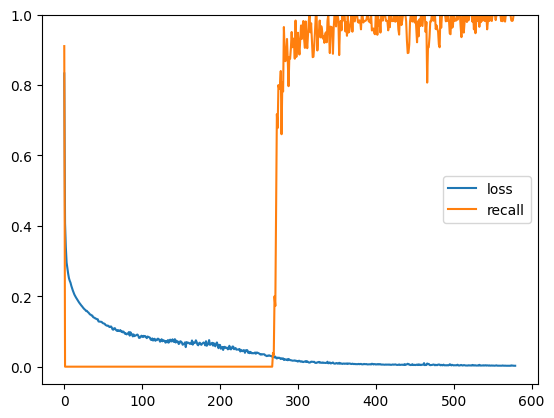

In [80]:
plt.figure()
plt.plot(history['loss'], label="loss")
plt.plot(history['recall'], label="recall")
plt.legend()
plt.ylim(-0.05, 1)

### Try the Model on an Example Clip

To confirm that the model is working as expected, let's test it on an example audio file (obtained from Youtube) of someone talking and then saying the phrase "turn on the office lights" at the end of the clip. We'll simulate how the model would be used in production, by predicting every 80ms (1280 samples) and plotting the predictions over time.

This clip is a good sanity test to confirm the model is performing in the right way, as it contains about ~30seconds of speech that does no contain the target phrase, but does contain related words (e.g, "lights") that should not result in an activation. So ideally, the model scores are low up to the end of the recording, where there should then be a spike right after the target spoken phrase.

Load data

In [70]:
ipd.display(ipd.Audio("./test_data/turn_on_the_office_lights_test_clip.wav"))

In [71]:
sr, dat = scipy.io.wavfile.read("./test_data/turn_on_the_office_lights_test_clip.wav")

sr, dat

(16000,
 array([-1099,  -689,   217, ...,  -153,  -106,     6],
       shape=(552000,), dtype=int16))

Pre-compute audio features using helper function

In [72]:
features = F._get_embeddings(dat)

features

array([[-28.648752 ,   2.659855 ,  23.821913 , ...,  -2.8287857,
         11.290624 ,  41.007473 ],
       [-32.71485  ,  13.615211 ,  27.11897  , ..., -17.515806 ,
         19.814672 ,  25.654663 ],
       [-14.341532 ,  18.603548 ,  18.577497 , ..., -22.821142 ,
         21.883734 ,  20.557467 ],
       ...,
       [  1.8575146,  13.036667 ,  -7.9644628, ..., -24.51238  ,
          3.2728171,   7.257418 ],
       [ -7.393012 ,  15.257349 ,  -7.765589 , ..., -23.30393  ,
         -0.6148179,   8.715682 ],
       [-10.846585 ,  19.999023 ,   1.1465082, ..., -22.06481  ,
         -2.3701906,  20.518202 ]], shape=(422, 96), dtype=float32)

Get predictions for each window

In [73]:
print("===== START INFERENCE OVER SLIDING WINDOWS =====")
num_frames = features.shape[0]
window_size = 28
scores = []

print(f"Total frames: {num_frames}")
print(f"Window size: {window_size}")
print(f"Total windows: {num_frames - window_size}")

for idx in tqdm(range(0, num_frames - window_size), total=num_frames - window_size):

    # Extract window
    window = features[idx:idx + window_size][None, ...]

    # Convert to Tensor
    window_tensor = torch.from_numpy(window)

    # Inference
    with torch.no_grad():
        score = float(fcn(window_tensor).detach().numpy())

    scores.append(score)

    # Optional lightweight debug log
    if idx % 1000 == 0:
        print(f"[DEBUG] idx={idx} | score={score:.4f}")

print("===== FINISHED INFERENCE =====")
print(f"Total scores collected: {len(scores)}")


===== START INFERENCE OVER SLIDING WINDOWS =====
Total frames: 422
Window size: 28
Total windows: 394


100%|██████████| 394/394 [00:00<00:00, 21835.23it/s]

[DEBUG] idx=0 | score=0.0026
===== FINISHED INFERENCE =====
Total scores collected: 394


In [74]:
scores

[0.0025661918334662914,
 0.0025079958140850067,
 0.002504245610907674,
 0.0037745616864413023,
 0.022687917575240135,
 0.007049255073070526,
 0.0028617174830287695,
 0.002502073999494314,
 0.0025265503209084272,
 0.00258122687228024,
 0.0026223475579172373,
 0.0026154411025345325,
 0.0025645385030657053,
 0.00251981639303267,
 0.0025422945618629456,
 0.002551940269768238,
 0.002543747192248702,
 0.002513682935386896,
 0.002521833172068,
 0.0024932636879384518,
 0.0024906869512051344,
 0.0024834659416228533,
 0.002483910182490945,
 0.0025024476926773787,
 0.0025240471586585045,
 0.0025222052354365587,
 0.002506645629182458,
 0.0024894077796489,
 0.0024942103773355484,
 0.002499587833881378,
 0.002544813323765993,
 0.002591259079053998,
 0.0026373108848929405,
 0.002669353736564517,
 0.0029260527808219194,
 0.0027867190074175596,
 0.002550714649260044,
 0.0024905637837946415,
 0.0024853944778442383,
 0.0024791958276182413,
 0.002490817103534937,
 0.0025059340987354517,
 0.002520333044230

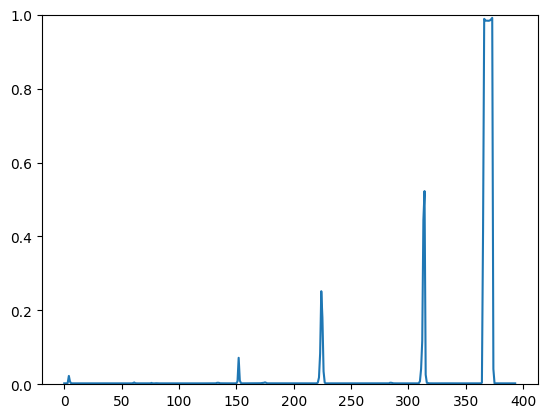

In [75]:
plt.figure()
_ = plt.plot(scores)
_ = plt.ylim(0, 1)